# Number Generation using DCGANs and MNIST Dataset

In [1]:
import torch #import all necessary datasets
import torchvision
import torchvision.transforms as T 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda') #gpu
transforms = T.Compose([ T.ToTensor(), T.Normalize((0.5,), (0.5,))]) #Normalize the images

In [3]:
train_data = torchvision.datasets.MNIST(root = './mnist/',train=True,download=True, transform=transforms)#download the datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, num_workers=4, pin_memory=True)#load the datasets

C:\Users\govind\AppData\Local\Programs\Python\Python36\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Generator

We will define the generator module here. This takes an input from the latent space and roughly creates a 28x28 image

In [4]:
class G(nn.Module):
    def __init__(self, latent_dim=100):
        super(G, self).__init__()
        self.latent_dim = latent_dim
        self.main_1 = nn.Sequential(
            nn.Linear(self.latent_dim, 256*7*7, bias=False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(0.2))
        self.conv_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=8, stride=4, bias=False),
            nn.Tanh()
        )

            
            
            
        
    def forward(self, x):
        
        x = self.main_1(x)
        x = x.view((-1, 256,7,7))
        x = self.conv_2(x)
        return x



## Discriminator

We will define the discriminator module here. This module takes a 28x28 image and outputs the probability of whether the image is fake or real.

In [5]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.conv_main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64 ,128, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.lin_main = nn.Sequential(
            nn.Linear(128*7*7, 1),
           
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv_main(x)
        x = x.view(x.shape[0], -1)
        return self.lin_main(x)

initialize the weights according to Ian GoodFellow's paper(initialize with mean 0 and variance 0.02)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Define models, loss and optimizers and apply weight initialization

In [7]:
d = D().to(device)
g = G().to(device)
d.apply(weights_init)
g.apply(weights_init)

criterion = nn.BCELoss()
optimD = optim.Adam(d.parameters(),lr = 0.001, betas=(0.5, 0.999))
optimG = optim.Adam(g.parameters(), lr=0.0001, betas=(0.5, 0.999))


Here we will train the GAN, Important thing to note here are 3 things:- Discriminator loss, Generator loss and discriminator output

We need to maximize discriminator loss, minimize generator loss and make sure our discriminator output is 0.5(can't distinguish between real or fake)  

Our generator loss doesn't generate sufficient gradients(as said by Ian GoodFellow) so we maximize its inverse (The loss is actually $log(1- g(x))$ and we need to minimize it but instead we will try to maximize $log(g(x))$ as a workaround as the first one doesn't provide sufficient gradients )

Since we are trying to maximize $log(g(x))$ we will say the inputs are real to counteract the fact that we are using a different loss(while training the generator)

In [8]:
epochs = 15
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        # train the discriminator
        #first train on real images
        d.zero_grad()#zero the gradients
        data = data[0].to('cuda')
        im_size = data.shape[0]
        label = torch.full((im_size,), 1.).unsqueeze(1).to('cuda')
        out = d(data)
        errD_real = criterion(out,label)#real image error
        errD_real.backward()
        D_x = out.mean().item()#get the predictions(should converge to 0.5)
        #now train on fake images
        fake_noise = torch.randn(im_size, 100, device='cuda')#generate fake images
        fake_im = g(fake_noise)
        fake_out = d(fake_im.detach())
        label.fill_(0)
        errD_fake = criterion(fake_out, label)#fake image error
        errD_fake.backward()
        optimD.step()
        errD = errD_fake + errD_real#total error is real error + fake error
        
        #train the generator
        g.zero_grad()#zero the gradients
        label.fill_(1.)#we want the labels as 1 since we are using a different loss
        out = d(fake_im)
        errG = criterion(out, label)#generator error
        errG.backward()
        optimG.step()
        

        #print the details for every 50th batch
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f'
                  % (epoch, epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x))

        
        

        
        


[0/15][0/469]	Loss_D: 1.3885	Loss_G: 0.7111	D(x): 0.5048
[0/15][50/469]	Loss_D: 0.0040	Loss_G: 7.6138	D(x): 0.9997
[0/15][100/469]	Loss_D: 0.0781	Loss_G: 4.7175	D(x): 0.9796
[0/15][150/469]	Loss_D: 0.0881	Loss_G: 4.7390	D(x): 0.9663
[0/15][200/469]	Loss_D: 0.0547	Loss_G: 3.9365	D(x): 0.9598
[0/15][250/469]	Loss_D: 0.0705	Loss_G: 4.3909	D(x): 0.9845
[0/15][300/469]	Loss_D: 0.0581	Loss_G: 4.1858	D(x): 0.9744
[0/15][350/469]	Loss_D: 0.0578	Loss_G: 4.2422	D(x): 0.9658
[0/15][400/469]	Loss_D: 0.0703	Loss_G: 3.3255	D(x): 0.9986
[0/15][450/469]	Loss_D: 0.1971	Loss_G: 4.2017	D(x): 0.8975
[1/15][0/469]	Loss_D: 0.1339	Loss_G: 3.5492	D(x): 0.9652
[1/15][50/469]	Loss_D: 0.0795	Loss_G: 4.5605	D(x): 0.9739
[1/15][100/469]	Loss_D: 0.0726	Loss_G: 4.4477	D(x): 0.9690
[1/15][150/469]	Loss_D: 0.1070	Loss_G: 5.6733	D(x): 0.9855
[1/15][200/469]	Loss_D: 0.0525	Loss_G: 6.0895	D(x): 0.9795
[1/15][250/469]	Loss_D: 0.0469	Loss_G: 5.3167	D(x): 0.9792
[1/15][300/469]	Loss_D: 0.0908	Loss_G: 6.6406	D(x): 0.9805
[1/

# Result

In [9]:
g.eval()
a = torch.randn(25*100, device='cuda').reshape(25, 100)

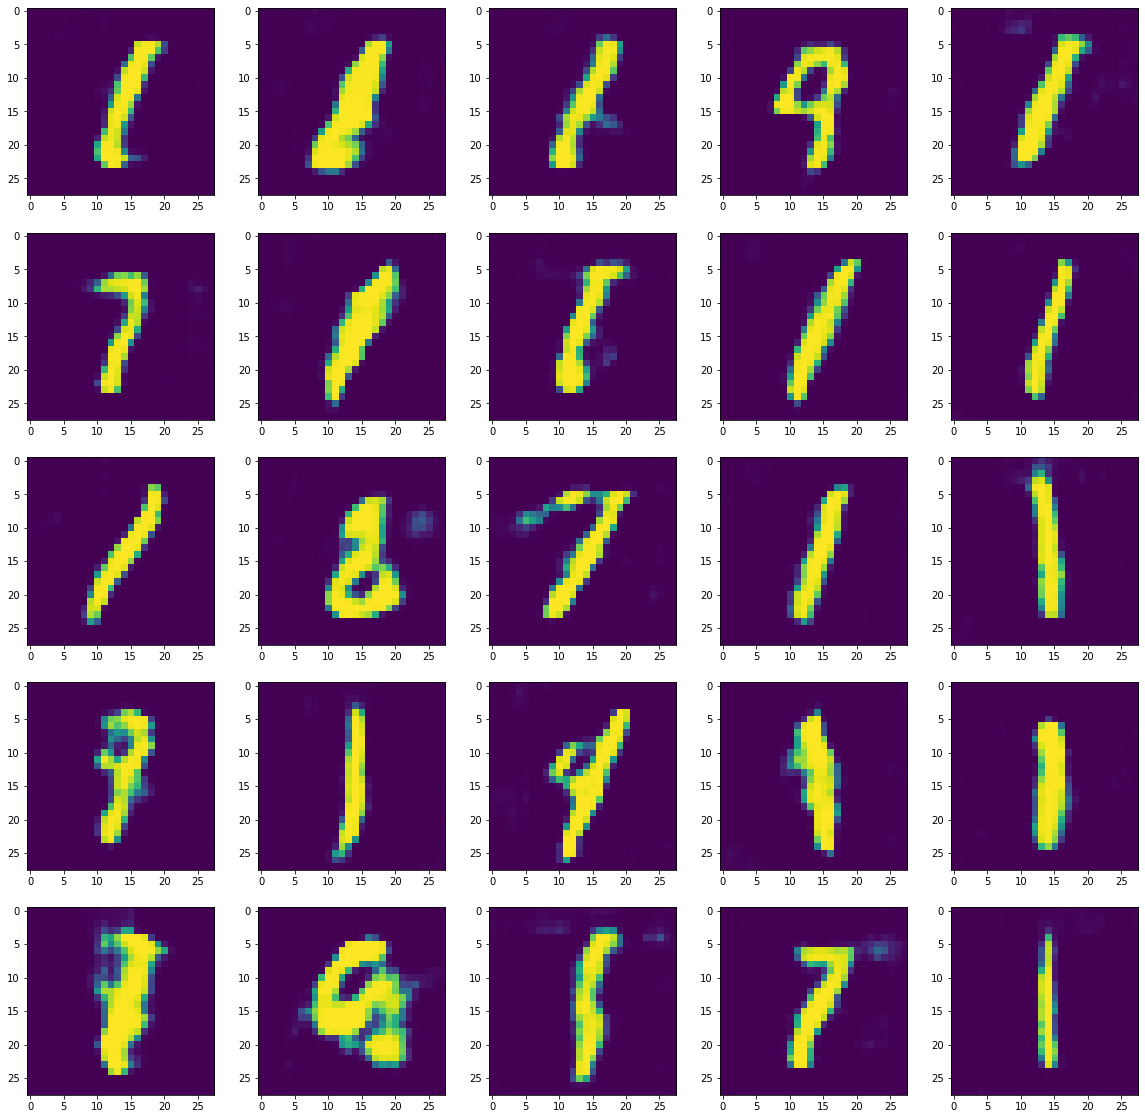

In [10]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(5,5,figsize=(20,20))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(g(a).detach().cpu()[5*i+j][0])